# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [5]:
len(loan_knowledge_chunks)

375

Let's verify the process worked as intended by checking our max document length.

In [6]:
max_chunk_length = 0

for chunk in loan_knowledge_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

742


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [8]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

#### 🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

#### ✅ ANSWER

In [9]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [10]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

#### Our RAG Application

Let's spin up the graph.

In [11]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

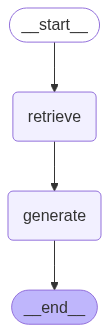

In [12]:
rag_graph

Let's test our chain out!

In [13]:
response = rag_graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})

In [14]:
response["response"]

"Applying for and securing a student loan in 2025 is not necessarily a terrible idea based on the provided context. The document discusses the process of determining eligibility, managing loan amounts when a student's grade level changes, and the importance of counseling and understanding loan limits. It emphasizes that loans can be properly managed with appropriate planning, counseling, and adherence to regulations. Therefore, whether it is a good or bad idea depends on individual circumstances, but from the information given, there is no indication that applying for a student loan in 2025 is inherently a terrible idea."

In [15]:
for context in response["context"]:
  print("Context:")
  print(context.page_content[:100])
  print("----")

Context:
student to earn that number of credits. For instance, if your school has a baccalaureate program tha
----
Context:
You must confirm that the borrower meets the definition of eligible borrower by doing the following:
----
Context:
Regardless of the counseling methods your school uses, it must document that the student received en
----
Context:
Pell Grant Lifetime Eligibility Used
Before awarding a Pell Grant, you must check the COD common rec
----


Let's see if it can handle a query that is totally unrelated to the source documents.

In [16]:
response = rag_graph.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [17]:
response["response"]

"I don't know"

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [18]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique_id}"
# LANGSMITH_PROJECT="pr-back-melon-40"
# os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT

In [21]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com/"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com/"

### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [19]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [23]:
os.environ["LANGSMITH_PROJECT"] = "pr-puzzled-backpack-3"

In [22]:
rag_graph.invoke({"question" : "What is the maximum loan amount I can get from the government to go to school these days?"}, {"tags" : ["Demo Run"]})['response']

'Based on the provided context, the maximum loan amount a dependent undergraduate student can receive from the government in a given academic year is up to $5,500, with no more than $3,500 of that being subsidized. For students with higher grade levels during the same academic year, the limits can increase; for example, a third-year dependent undergraduate may be eligible for up to $7,500 in total, with up to $5,500 subsidized. Additionally, there are aggregate limits for different types of students, such as $31,000 for dependent undergraduates and higher limits for independent undergraduates and graduate students.\n\nHowever, the exact maximum loan amount for any individual depends on their specific circumstances, program, and eligibility, as outlined in the program guidelines.'

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

##### ✅ ANSWER

Screenshot Link: https://imgur.com/a/c7x14f6

- The Graph took 2.35s to execute and included calls to:
    - retrieve node which took 0.26s
    - and the generate node which took 2.08s
- It also shows the 4 documents that were retrieved from the VectorStore
- Finally it shows the input and output of the graph

## Task 5: Loading Our Testing Set

In [25]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

fatal: destination path 'DataRepository' already exists and is not an empty directory.


In [26]:
import pandas as pd

test_df = pd.read_csv("DataRepository/student_loan_rag_test_data.csv")

In [28]:
test_df

,Unnamed: 0,question,context,answer,idx
0,0,What does 'verification' mean in the FAFSA pro...,Applications_and_Verification_Guide.pdf,Verification is the process of confirming the ...,0
1,1,What components make up the Cost of Attendance...,Academic_Calenders_Cost_of_Attendance_and_Pack...,"COA includes tuition, fees, room and board, bo...",1
2,2,What components make up the Cost of Attendance...,Academic_Calenders_Cost_of_Attendance_and_Pack...,"COA includes tuition, fees, room and board, bo...",2
3,3,What components make up the Cost of Attendance...,Academic_Calenders_Cost_of_Attendance_and_Pack...,"COA includes tuition, fees, room and board, bo...",3
4,4,What is the FAFSA Simplification Act and what ...,Applications_and_Verification_Guide.pdf,The FAFSA Simplification Act overhauled the fe...,4
5,5,What is the FAFSA Simplification Act and what ...,Applications_and_Verification_Guide.pdf,The FAFSA Simplification Act overhauled the fe...,5
6,6,What is the difference between subsidized and ...,The_Direct_Loan_Program.pdf,Subsidized loans are need-based and the govern...,6
7,7,What components make up the Cost of Attendance...,Academic_Calenders_Cost_of_Attendance_and_Pack...,"COA includes tuition, fees, room and board, bo...",7
8,8,What is the difference between subsidized and ...,The_Direct_Loan_Program.pdf,Subsidized loans are need-based and the govern...,8
9,9,What is the difference between subsidized and ...,The_Direct_Loan_Program.pdf,Subsidized loans are need-based and the govern...,9


Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [27]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-student-loan-rag"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="Student Loan RAG Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

LangSmithConflictError: Conflict for /datasets. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/datasets', '{"detail":"Dataset with this name already exists."}')

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [30]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [31]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4o-mini", tags=["eval_llm"])

cot_qa_evaluator = LangChainStringEvaluator("cot_qa",  config={"llm":eval_llm}, prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    rag_graph.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

View the evaluation results for experiment: 'Base RAG Evaluation-1bda439d' at:
https://smith.langchain.com/o/c2cfcbd8-d5df-509f-8f0e-973ec8ab5a6b/datasets/43bd34f9-8839-4991-a601-ffc67dc2ef8a/compare?selectedSessions=05d4e506-e178-4b71-bf86-ec32b802e559




0it [00:00, ?it/s]

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

#### ✅ ANSWER
- There were 23 evaluations completed in the experiment 
- When allowing the LLM to be the judge all 23 LLM outputs were found to be correct
- Only 4 / 23 answers were considered "dope"
- The average accuracy score when the LLM output was compared to acceptable answers was ~8.35 out of 10. Again, quite accurate.
- There was one evaluation where the latency was extremely high (23s). The question was "What is the difference between subsidized and unsubsidized Direct Loans?"
  - Give more time it is necessary to investigate the cause of high latency and make adjustments improve this and similar scenarios if they are in fact common.
